### Protective Strategies 

In this <a href="https://www.python.org/doc/essays/blurb/">Python</a> notebook, we will dive into options hedging strategies named as protective strategies.  
This hedging strategy is designed to insure an investor’s asset position (long buy or short sell). 

- An investor who owns an asset and wishes to be protected from falling asset values can insure his asset by buying a put option written on the same asset.This combination of owning an asset and purchasing a put option on that asset is called a protective put.
- In contrast, an investor shorting an asset who will experience a loss if the asset price rises in value can insure his position by purchasing a call option written on the same asset. Such a combination of selling an asset and purchasing a call option on that asset is called a protective call.

To do so, we have to generate multiple scenarios of the underlying asset since its evolution is completely random . To generate such underlying monte_carlo simulations, we will use practical functions of the <a href="https://finance.math.upmc.fr/en/enseignements/1_2_probas_numeriques/">Numerical Probability</a> course from the master's degree <a href="https://finance.math.upmc.fr/en/">M2 Probabilités et Finance</a> taught by both <a href="https://www.lpsm.paris/users/pages/index">Gilles Pagès</a> and <a href="https://perso.lpsm.paris/~vlemaire/site.html">Vincent Lemaire</a> . With their practical hands-on notebooks, we can easily see and plot various scenarios of underlying asset . 

Hence, we import a library called `ncxs99_pricers` where we can find all our Black & Scholes Pricers and `ncxs99_utilities` where we can find all the functions for underlying asset scenarios simulations from the M2 Probability and Finance notebooks and more. We will not provide these functions directly but you can easily implement them to well understand what's going on behind the scenes 😉.

In [1]:
from ncxs99_utilities import black_scholes_1d
from ncxs99_pricers import EuropeanOptions

We then provide all the necessary parameters the function `black_scholes_1d` which displays all the underlying asset scenarios. Here is the <a href="https://www.geeksforgeeks.org/python-docstrings/">docstring</a> of the function : 

The Black and Scholes Process is defined by the following <a href="https://ethz.ch/content/dam/ethz/special-interest/mavt/dynamic-systems-n-control/idsc-dam/Lectures/Stochastic-Systems/SDE.pdf">Stochastic Differential Equation</a>

Let $S_t$ be the solution of the SDE on $[0,T]$
$$
    \operatorname{d}\!S_t = r S_t \operatorname{d}\!t + \sigma S_t \operatorname{d}\!B_t, \quad S_0 = x
$$
Then $S_t$ is given by : 
$$
    S_t = x \exp \bigl((r- \sigma^2/2) t + \sigma B_t \bigr)
$$


`black_scholes_1d` : Simulate paths of Black-Scholes process
-    Args:
       - n_times: Number of timesteps
       - n_paths: Number of paths 
       - final_time: Final time of simulation
       - init_value: `S0`
       - r: Interest rate
       - sigma: Volatility
       - random_state: `np.random.Generator` used for simulation
-    Returns:
       - `np.array` of shape `(n_times+1, n_paths)` containing the paths 
       
We then define the function parameters and plot our results to see what happens .

In [2]:
N = 5 
M = 500
S0 = 100
r, sigma = 0.1, 0.2
D = 0 
T = 1 
K = 101
St = black_scholes_1d(N, M, init_value=S0, r=r, sigma=sigma) # Paths of BS Process

In [3]:
St[:10] # display the first 10 element of the underlying asset array 

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [ 98.03267023,  99.8194199 , 104.65059726, ...,  91.48069188,
         88.74647955,  84.99576492],
       [ 91.06282049, 116.43584536, 119.69229154, ...,  85.09293162,
         80.80692469,  83.00176444],
       [ 98.53874179,  93.83873036, 107.51243821, ...,  89.7233008 ,
         77.62671273,  82.56055006],
       [ 89.59454966,  97.83194143, 102.70781414, ...,  99.37996269,
         79.95752008,  78.62657923],
       [ 85.85120728, 103.81948361, 103.32778403, ...,  90.89875262,
         82.21504254,  80.92530096]])

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
sns.set_theme()

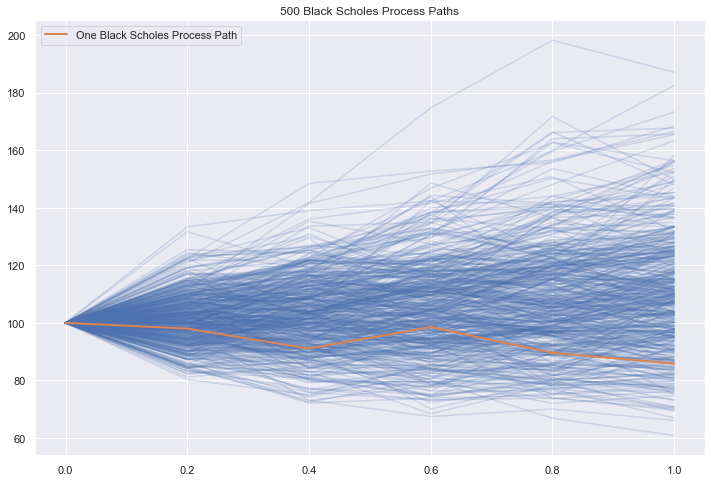

In [5]:
plt.figure(figsize=(12,8))
times = np.arange(N+1)*(T / N)
for S in St.T:
    sns.lineplot(x=times, y=S, color='C0', alpha=0.2)
ax = sns.lineplot(x=times, y=St[:,0], color='C1', lw=2, label='One Black Scholes Process Path')
ax.set(title=f"{M} Black Scholes Process Paths");

We can see in the preceding graph, 500 simulations of Black and Scholes Process. 

The next step is to store the last maturity time values of the BS process that is : Values of $S_t$ for which $t=T$ which is $1$ in our case . Why ? Because, we want to represent the <a href="https://www.math.fsu.edu/~paris/FMexam/DM%20Module%201.pdf">Payoff</a> of covered options strats and because the payoff is generally computed at the maturity for <a href="https://www.schwab.com/options/what-is-trading-options">options</a> . 

In [6]:
stock_prices = St.T[:,-1]  # We store the last values at the maturity T of our stock_prices vector 

We then <a href="https://www.geeksforgeeks.org/introduction-to-sorting-algorithm/">sort</a> our stock_prices vector in order to well represent the payoff since our simulations are purely random. To sort our vector, we used <a href="https://numpy.org/doc/stable/reference/generated/numpy.sort.html">`np.sort`</a> which has <a href="https://blog.finxter.com/how-to-sort-in-one-line/#:~:text=The%20runtime%20complexity%20of%20the,log(n))%20on%20average.">nlog(n)</a> complexity which the most efficient algorithm to sort tables in modern programming languages .

In [7]:
stock_prices = np.sort(stock_prices) # sort our stock_prices

### Protective Call Strategy

$\textit{Protective Call}$ : A protective call is an investment strategy constructed by selling a stock
and buying an $OTM$ call option on the same stock.

The value of the strategy at time $t$ is given by :
$$
\Pi_t = - S_t + C(S_t,t;K,T)
$$



The payoff of this strategy a $T$ is : 

$$
\Psi(S_T) = - S_T + C(S_T,T;K,T)= 
\begin{cases} 
- K & \text{if } S_T \geq K, \\
- S_T & \text{if } S_T < K.
\end{cases}
$$

The profit of this strategy is given by :

$$
\Gamma(S_T) = \Psi(S_T) - \Pi_t= - S_T + C(S_T,T;K,T) + S_t - C(S_t, t; T, K)= 
\begin{cases} 
S_t - K - C(S_t, t; K, T) & \text{if } S_T \geq K, \\
S_t - S_T - C(S_t, t; K, T) & \text{if } S_T < K.
\end{cases}
$$

Before plotting the Profit diagram of the protective call strategy, we have to compute the option premium . Thanks to our `EuropeanOptions` class we implemented in previous notebook you can find on my github <a href="https://github.com/Ncxs99/Financial-Mathematics/blob/master/Equity%20Derivatives%20Pricing/European%20Options/Europea_Options.ipynb">Ncxs99</a> . We then use our class to directly find the premium of the corresponding $OTM$ option .

In [8]:
premium = EuropeanOptions(S0,K,T,sigma,r,D)
premium = premium.Call_Black_Scholes()
premium

12.684983116938433

After compute the option price , then here is how we proceed to display the profit of the protective call strategy : 
- Compute `stock_profit` which is in fact the profit the investor can make only the stock options . 
`stock_profit` = -`stock_prices` + `S0` where `S0` is the acquiring cost the underlying asset 

- Compute the `long_call_profit` which is in fact the profit earn only on the options positions . `long_call_profit` = `Payoff_long_Call_Option_Maturity` - `Premium`

In [9]:
stock_profit = - stock_prices + S0  # stock_profit 
long_call_profit = np.maximum(0, stock_prices - K) - premium  # long_call_profit 
protective_call_profit = stock_profit + long_call_profit # protective_call_profit 

We then plot the protective put

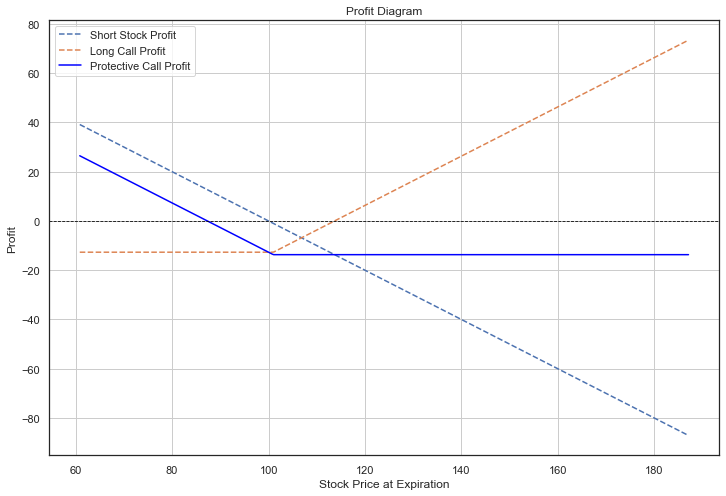

In [10]:
sns.set_theme(style='white')
plt.figure(figsize=(12, 8))
plt.plot(stock_prices, stock_profit, label="Short Stock Profit", linestyle='--')
plt.plot(stock_prices, long_call_profit, label="Long Call Profit", linestyle='--')
plt.plot(stock_prices, protective_call_profit, label="Protective Call Profit", color="blue")
plt.axhline(0, color='black', linewidth=0.8, linestyle="--")
plt.title("Profit Diagram")
plt.xlabel("Stock Price at Expiration")
plt.ylabel("Profit")
plt.legend()
plt.grid()
plt.show()

### Protective Call Greeks 

Protective call greeks are just the greeks of a long call option except for the delat which is negative . Here are the main protective call greeks : 

- Negative delta

- Positive Gamma

- Positive Vega

- Negative Theta 

- Positive Rho

In [11]:
delta_call = EuropeanOptions(stock_prices, K, T, sigma, r, D)
delta_call = delta_call.Delta_Call()


delta_protective_call = - 1 + delta_call

In [12]:
gamma_call = EuropeanOptions(stock_prices, K, T, sigma, r, D)
gamma_call = gamma_call.Gamma_Call()


gamma_protective_call = gamma_call

In [13]:
vega_call = EuropeanOptions(stock_prices, K, T, sigma, r, D)
vega_call = vega_call.Vega_Call()


vega_protective_call = vega_call

In [14]:
theta_call = EuropeanOptions(stock_prices, K, T, sigma, r, D)
theta_call = theta_call.Theta_Call()


theta_protective_call = theta_call

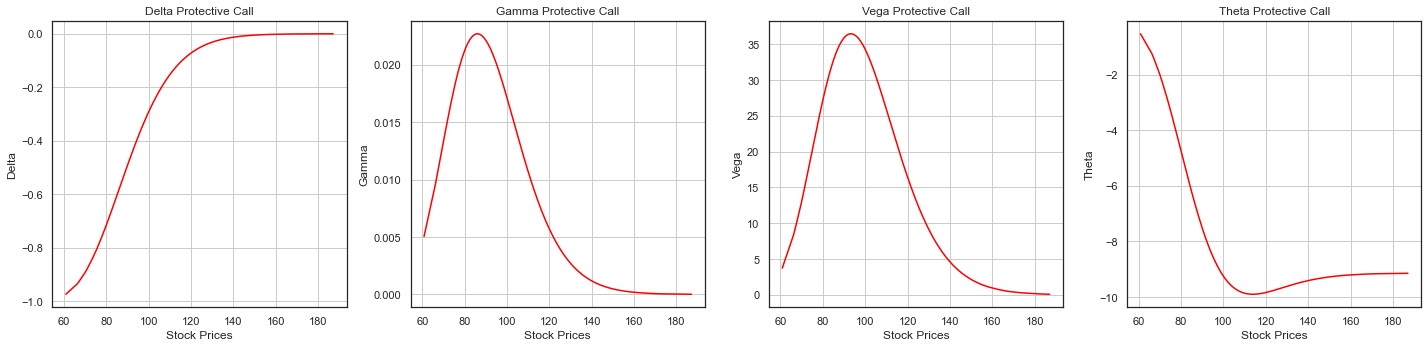

In [15]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

# Delta Protective Call
axes[0].plot(stock_prices, delta_protective_call, c='red')
axes[0].set_title('Delta Protective Call')
axes[0].set_xlabel('Stock Prices')
axes[0].set_ylabel('Delta')
axes[0].grid()

# Gamma Protective Call
axes[1].plot(stock_prices, gamma_protective_call, c='red')
axes[1].set_title('Gamma Protective Call')
axes[1].set_xlabel('Stock Prices')
axes[1].set_ylabel('Gamma')
axes[1].grid()

# Vega Protective cCall
axes[2].plot(stock_prices, vega_protective_call, c='red')
axes[2].set_title('Vega Protective Call')
axes[2].set_xlabel('Stock Prices')
axes[2].set_ylabel('Vega')
axes[2].grid()

# Theta Protective Call
axes[3].plot(stock_prices, theta_protective_call, c='red')
axes[3].set_title('Theta Protective Call')
axes[3].set_xlabel('Stock Prices')
axes[3].set_ylabel('Theta')
axes[3].grid()

# Adjust layout
plt.tight_layout()
plt.show()

### Protective Put Strategy

$\textit{Protective Put}$ : A protective put is a hedging strategy constructed by buying a stock and
buying an $OTM$ put option on the same stock.

The value of the strategy at time $t$ is given by :
$$
\Pi_t =  S_t + P(S_t,t;K,T)
$$



The payoff of this strategy a $T$ is : 

$$
\Psi(S_T) = S_T + P(S_T,T;K,T)= 
\begin{cases} 
S_T & \text{if } S_T \geq K, \\
K & \text{if } S_T < K.
\end{cases}
$$

The profit of this strategy is given by :

$$
\Gamma(S_T) = \Psi(S_T) - \Pi_t= S_T + P(S_T,T;K,T) - S_t - P(S_t, t; T, K)= 
\begin{cases} 
S_T - S_t - P(S_t, t; K, T) & \text{if } S_T \geq K, \\
K - S_t - P(S_t, t; K, T) & \text{if } S_T < K.
\end{cases}
$$

Before plotting the Profit diagram of the protective put strategy, we have to compute the option premium . Thanks to our `EuropeanOptions` class we implemented in previous notebook you can find on my github <a href="https://github.com/Ncxs99/Financial-Mathematics/blob/master/Equity%20Derivatives%20Pricing/European%20Options/Europea_Options.ipynb">Ncxs99</a> . We then use our class to directly find the premium of the corresponding $OTM$ option .

In [16]:
premium = EuropeanOptions(S0,K,T,sigma,r,D)
premium = premium.Put_Black_Scholes()
premium

4.073562338570337

After compute the option price , then here is how we proceed to display the profit of the covered call strategy : 
- Compute `stock_profit` which is in fact the profit the investor can make only the stock options . 
`stock_profit` = `stock_prices` - `S0` where `S0` is the acquiring cost the underlying asset 

- Compute the `long_put_profit` which is in fact the profit earn only on the options positions . `long_put_profit` = `Payoff_long_Put_Option_Maturity` - `Premium`

In [17]:
stock_profit = stock_prices - S0  # stock_profit 
long_put_profit = np.maximum(0, K - stock_prices) - premium  # long_put_profit 
protective_put_profit = stock_profit + long_put_profit # protective_put_profit

We then plot the protective put

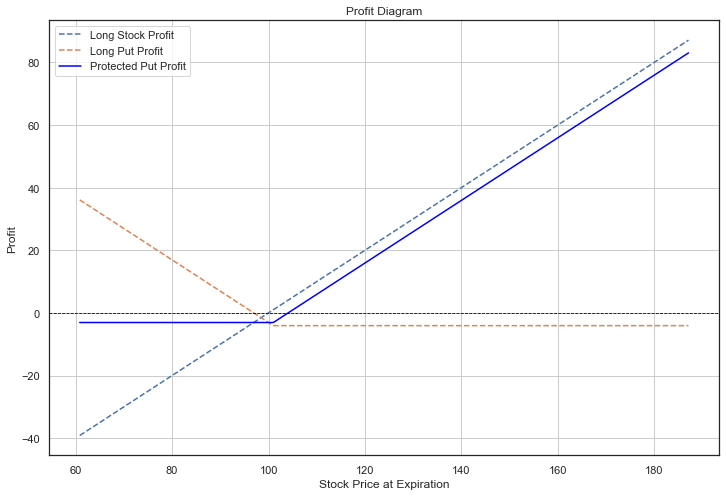

In [18]:
sns.set_theme(style='white')
plt.figure(figsize=(12, 8))
plt.plot(stock_prices, stock_profit, label="Long Stock Profit", linestyle='--')
plt.plot(stock_prices, long_put_profit, label="Long Put Profit", linestyle='--')
plt.plot(stock_prices, protective_put_profit, label="Protected Put Profit", color="blue")
plt.axhline(0, color='black', linewidth=0.8, linestyle="--")
plt.title("Profit Diagram")
plt.xlabel("Stock Price at Expiration")
plt.ylabel("Profit")
plt.legend()
plt.grid()
plt.show()

### Protective Put Greeks 

Protective put greeks are just the greeks of a long put option except for the delat which is positive . Here are the main protective call greeks : 

- Positive delta

- Positive Gamma

- Positive Vega

- Negative Theta 

- Negative Rho 

In [19]:
delta_put = EuropeanOptions(stock_prices, K, T, sigma, r, D)
delta_put = delta_put.Delta_Put()


delta_protective_put =  1 + delta_put

In [20]:
gamma_put = EuropeanOptions(stock_prices, K, T, sigma, r, D)
gamma_put = gamma_put.Gamma_Put()


gamma_protective_put = gamma_put

In [21]:
vega_put = EuropeanOptions(stock_prices, K, T, sigma, r, D)
vega_put = vega_put.Vega_Put()


vega_protective_put = vega_put

In [22]:
theta_put = EuropeanOptions(stock_prices, K, T, sigma, r, D)
theta_put = theta_put.Theta_Put()


theta_protective_put = theta_put

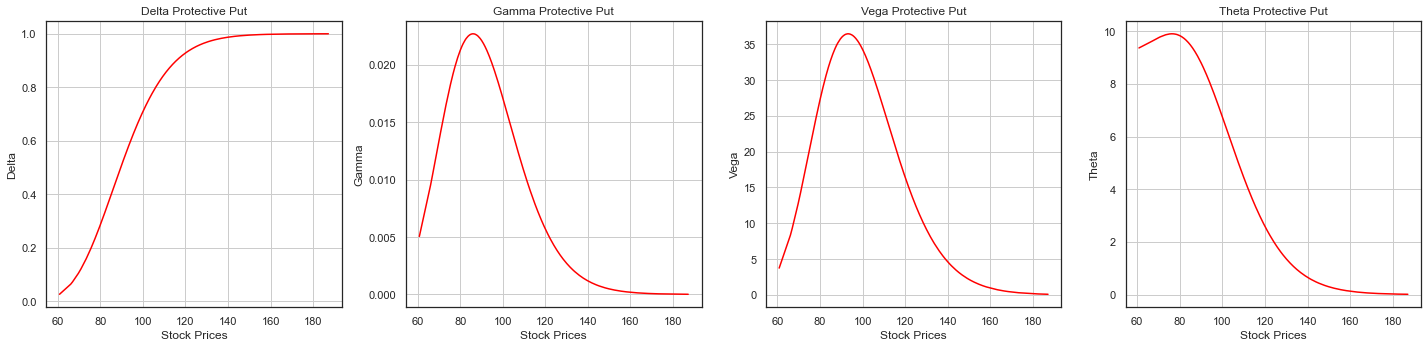

In [23]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

# Delta Protective Put
axes[0].plot(stock_prices, delta_protective_put, c='red')
axes[0].set_title('Delta Protective Put')
axes[0].set_xlabel('Stock Prices')
axes[0].set_ylabel('Delta')
axes[0].grid()

# Gamma Protective Put
axes[1].plot(stock_prices, gamma_protective_put, c='red')
axes[1].set_title('Gamma Protective Put')
axes[1].set_xlabel('Stock Prices')
axes[1].set_ylabel('Gamma')
axes[1].grid()

# Vega Protective Put
axes[2].plot(stock_prices, vega_protective_put, c='red')
axes[2].set_title('Vega Protective Put')
axes[2].set_xlabel('Stock Prices')
axes[2].set_ylabel('Vega')
axes[2].grid()

# Theta Protective Put
axes[3].plot(stock_prices, theta_protective_put, c='red')
axes[3].set_title('Theta Protective Put')
axes[3].set_xlabel('Stock Prices')
axes[3].set_ylabel('Theta')
axes[3].grid()

# Adjust layout
plt.tight_layout()
plt.show()